### Self-Reflection in RAG

* generates an initial answer using retrieved context
* reflects on that answer with dedicated self-critic LLM Step
* if unsatisfied, it can revise the query, retrieve again or regenerate the answer.

In [1]:
import os
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS


d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
#load ll model
from langchain.chat_models import init_chat_model

model = init_chat_model(model="groq:llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001C4E1A43AD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C4E1BB5DD0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
lc_urls=['https://docs.langchain.com/oss/python/langchain/agents',
'https://docs.langchain.com/oss/python/langchain/tools',
'https://docs.langchain.com/oss/python/langchain/streaming']

lc_docs = WebBaseLoader(web_paths=lc_urls).load()
lc_chunks = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100).split_documents(lc_docs)
print(f"Number of langchain chunks: {len(lc_chunks)}")
vectorstore = FAISS.from_documents(
    documents=lc_chunks,
    embedding=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
)

lc_retriever = vectorstore.as_retriever()

Number of langchain chunks: 87


In [4]:
#defining state schema
from pydantic import BaseModel
from typing import List
from langchain_core.documents import Document
class SelfReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection:str = ""
    revised: bool = False
    attempts: int = 0

In [5]:
#defining nodes

# retriever

def retrieve_docs(state:SelfReflectionState)->SelfReflectionState:
    docs = lc_retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": docs})

#generate_answer

def generate_answer(state:SelfReflectionState)->SelfReflectionState:

    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])

    prompt = f"""
                Use the following context to answer the following question.

                context: {context}
                question: {state.question}
                """
    
    answer = model.invoke(prompt).content.strip()
    return state.model_copy(update={"answer":answer, "attempts": state.attempts + 1})

In [6]:
#self-reflection node

def reflect_on_answer(state:SelfReflectionState)->SelfReflectionState:

    prompt = f"""
Reflect on the following answer to see if it fully addressedd the question.
State YES if it is complete and correct, or NO with an explanation

question: {state.question}

answer: {state.answer}

Respond like:
Reflection: YES or NO"
Explanation: """
    
    result = model.invoke(prompt).content
    is_ok = "relection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [7]:
#finalizer

def finalize(state:SelfReflectionState)->SelfReflectionState:
    return state

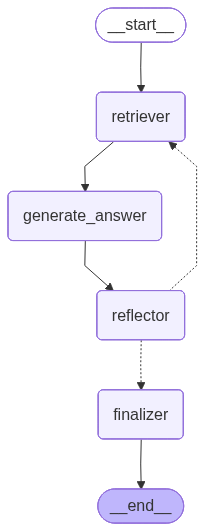

In [19]:
#langgraph graph workflow

from langgraph.graph import StateGraph, START, END

graph = StateGraph(SelfReflectionState)

graph.add_node("retriever", retrieve_docs)
graph.add_node("generate_answer", generate_answer)
graph.add_node("reflector", reflect_on_answer)
graph.add_node("finalizer", finalize)

graph.add_edge(START, "retriever")
graph.add_edge("retriever", "generate_answer")
graph.add_edge("generate_answer", "reflector")
graph.add_conditional_edges("reflector", lambda s : "finalizer" if [not s.revised or s.attempts >= 2] else "retriever",
                            {"finalizer":"finalizer", "retriever":"retriever"})
graph.add_edge("finalizer", END)

graph_builder = graph.compile()
graph_builder



In [21]:
#run the agent

if __name__=="__main__":
    user_query = "what are the benefits of agents in langchain"
    init_state = SelfReflectionState(question=user_query)
    result = graph_builder.invoke(init_state)

    print(f"\n Final Answer:\n {result['answer']}")
    print(f"\n Reflection Log:\n {result['reflection']}")
    print(f"\nTotal Attempts: \n {result['attempts']}")



 Final Answer:
 Based on the provided context, the benefits of agents in LangChain are:

1. **Improved User Experience (UX)**: Agents can display output progressively, even before a complete response is ready, which enhances the responsiveness of applications built on Large Language Models (LLMs).
2. **Live Feedback**: LangChain's streaming system allows you to surface live feedback from agent runs to your application, enabling real-time updates and a more interactive experience.
3. **Flexibility**: Agents can be customized to use a custom state schema to remember additional information during the conversation, which can be thought of as the short-term memory of the agent.
4. **Conversation History**: Agents maintain conversation history automatically through the message state, allowing for a more contextual and informed conversation.
5. **Scalability**: Agents can handle multiple steps and display intermediate progress, making them suitable for complex conversations and tasks that re